# Test Vector Search and automatic Resolution Generation with ChatGPT 3.5

In [21]:
# Set env var OPENAI_API_KEY or load from a .env file:
import dotenv
import os
import pandas as pd
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns

from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage
from langchain_community.document_loaders import Docx2txtLoader

from sklearn.metrics.pairwise import cosine_similarity


dotenv.load_dotenv(".env")

True

In [2]:
# Set up the vector store
persist_directory='./embeddedincidents'
vectordb = Chroma(persist_directory=persist_directory, embedding_function=OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_KEY"), model="text-embedding-3-small"))

In [3]:
# read train_tickets.csv int pandas dataframe df
df = pd.read_csv('train_tickets.csv', index_col=0)
print("Number of incidents: ", df.shape[0])
print(df.head())

Number of incidents:  236
                                               Title  \
0                               Need Ethernet access   
1  Create new account and share the username and ...   
2                     FW: Myspace Login Issue-- Ania   
3                  Login credetials are not working.   
4            New Account is needed for a new joinee.   

                                          Resolution  class  
0  Please connect the LAN cable to the red port o...     41  
1  Go to URL : accountsetup.com, Enter personal d...     35  
2  Go to URL : password.reset.com, Enter you logi...     36  
3  Go to URL : password.reset.com, Enter you logi...     36  
4  Go to URL : accountsetup.com, Enter personal d...     35  


In [4]:
# check if vector search with title yields the correct resolution
retriever=vectordb.as_retriever(search_kwargs={'k': 3})
retrieval_results = pd.DataFrame(columns=['title', 'true_resolution','retrieved_resolutions','match'])
# iterate over rows in df
for index, row in df.iterrows():
    retrieved_content = []
    docs = retriever.invoke(row['Title'])
    match = False
    for doc in docs:
        inc = doc.metadata["source"]
        content = doc.page_content
        retrieved_content.append(content)
        # delete "incident_data\\" from inc
        if content== row['Resolution']:
            match = True
    retrieval_results.loc[len(retrieval_results)] = pd.Series({'title': row['Title'], 'true_resolution': row['Resolution'], 'retrieved_resolutions': retrieved_content, 'match': match})

    

In [5]:
#  print first 10 rows of retrieval_results
print(retrieval_results.head(10))
# print match rate, format as percent with two decimal places
print("Match rate: ", "{:.2%}".format(retrieval_results['match'].sum()/retrieval_results.shape[0]))

                                               title  \
0                               Need Ethernet access   
1  Create new account and share the username and ...   
2                     FW: Myspace Login Issue-- Ania   
3                  Login credetials are not working.   
4            New Account is needed for a new joinee.   
5  Request to configure the system to share it am...   
6             Needs permission wifi access to laptop   
7                            LAN not working in a VM   
8                                Wifi access needed.   
9                    My Space QA application is down   

                                     true_resolution  \
0  Please connect the LAN cable to the red port o...   
1  Go to URL : accountsetup.com, Enter personal d...   
2  Go to URL : password.reset.com, Enter you logi...   
3  Go to URL : password.reset.com, Enter you logi...   
4  Go to URL : accountsetup.com, Enter personal d...   
5  They won't be able to access other profiles 

In [13]:
# add match column to df
df['match'] = None
for index, row in df.iterrows():
    current_class = row['class']
    # write all resolutions that match the class of the current incident in a list
    resolutions = df.loc[df['class'] == current_class]['Resolution'].tolist()
    # check if list in column retrieved_resolutions of retrieval_results at index overlaps with resolutions list
    match = False
    for i in retrieval_results.at[index, 'retrieved_resolutions']:
        if i in resolutions:
            match = True
            # stopp loop if match is found
            break
    df.at[index, 'match'] = match
df.to_csv('train_tickets_with_match.csv')

In [8]:
# define prompt template
SYSTEM_TEMPLATE = """
Answer the user question and explain all necessary steps to the solution. Choose just the single most solution option from the solutions proposed in the context. 
If the context does not contain any relevant information to answer the question, just say “I don’t know”.
<context>
{context}
</context>
"""

question_answering_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SYSTEM_TEMPLATE,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [9]:
# iterate over rows in df and get ai_answer
df['ai_answer'] = None
for index, row in df.iterrows():

    chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.2, openai_api_key=os.getenv("OPENAI_KEY"))
    document_chain = create_stuff_documents_chain(chat, question_answering_prompt)

    def parse_retriever_input(params: Dict):
        """return llm response as string"""
        return params["messages"][-1].content

    retrieval_chain = RunnablePassthrough.assign(
        context=parse_retriever_input | retriever,
    ).assign(
        answer=document_chain,
    )
    ai_answer = retrieval_chain.invoke(
        {
            "messages": [
                HumanMessage(content=row['Title'])
            ],
        }
    )
    df.at[index, 'ai_answer'] = ai_answer
    # save df results to csv every 5 iterations
    if index % 5 == 0:
        df.to_csv('train_tickets_with_ai_answer.csv')
# save final results
df.to_csv('train_tickets_with_ai_answer.csv')

In [10]:
# print first 10 rows of df
df.head()

,Title,Resolution,class,match,ai_answer
0,Need Ethernet access,Please connect the LAN cable to the red port o...,41,False,"{'messages': [content='Need Ethernet access'],..."
1,Create new account and share the username and ...,"Go to URL : accountsetup.com, Enter personal d...",35,False,{'messages': [content='Create new account and ...
2,FW: Myspace Login Issue-- Ania,"Go to URL : password.reset.com, Enter you logi...",36,False,{'messages': [content='FW: Myspace Login Issue...
3,Login credetials are not working.,"Go to URL : password.reset.com, Enter you logi...",36,False,{'messages': [content='Login credetials are no...
4,New Account is needed for a new joinee.,"Go to URL : accountsetup.com, Enter personal d...",35,False,{'messages': [content='New Account is needed f...


In [19]:
# calculate cosine similarities between Resolution and ai_answer
embeddings_model=OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_KEY"), model="text-embedding-3-small")
df['consine_sim_ai_answer'] = None
for index, row in df.iterrows():

    # calculate embeddings for ai_anwer
    embeddings_ai_anwer = embeddings_model.embed_documents(
        [
            row['ai_answer']['answer']
        ]
    )

    # calculate embeddings for Resolution
    embeddings_resolution = embeddings_model.embed_documents(
        [
            row['Resolution']
        ]
    )

    # calculate cosine similarity
    cosine_sim = cosine_similarity([embeddings_ai_anwer[0]], [embeddings_resolution[0]])[0].tolist()[0]
    df.at[index, 'consine_sim_ai_answer'] = cosine_sim

# save summary_distances to excel
df.to_csv('train_tickets_with_ai_answer_and_cosine_sim.csv')

In [35]:
# calculate confusion matrix and accuracy
def find_nonmatch(ai_answer: dict):
    return 'I don’t know' not in ai_answer['answer']

df['found_match'] = df['ai_answer'].apply(find_nonmatch)

# calculate confusion matrix with df['match'] as true values and df['nonmatch'] as predicted values
confusion_matrix = pd.crosstab(df['match'], df['found_match'])
print(confusion_matrix)
# calculate accuracy
accuracy = (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,1]) / df.shape[0]
print("Accuracy: ", "{:.2%}".format(accuracy))

found_match  False  True 
match                    
False           11     72
True            18    135
Accuracy:  61.86%


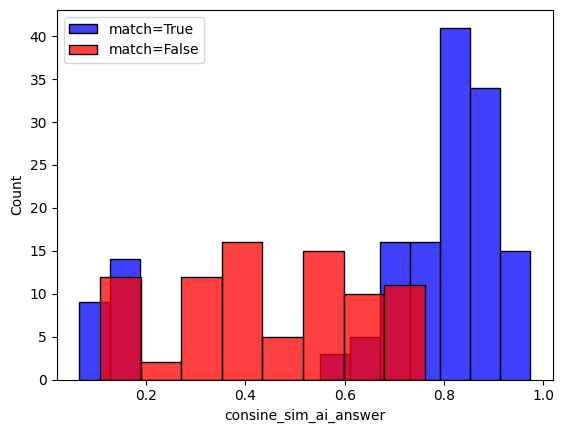

In [24]:
# visualize the distribution of cosine similarities where match is True df[df['match']==True]['consine_sim_ai_answer'] and df[df['match']==False]['consine_sim_ai_answer'] in different colors
sns.histplot(df[df['match']==True]['consine_sim_ai_answer'], color='blue', label='match=True', kde=False)
sns.histplot(df[df['match']==False]['consine_sim_ai_answer'], color='red', label='match=False', kde=False)
plt.legend()
plt.show()


